## Importing needed libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder


## Dataset Handling

In [2]:
df = pd.read_csv('updated_pollution_dataset.csv')
print("Dataset Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())

Dataset Shape: (5000, 10)

Missing Values:
 Temperature                      0
Humidity                         0
PM2.5                            0
PM10                             0
NO2                              0
SO2                              0
CO                               0
Proximity_to_Industrial_Areas    0
Population_Density               0
Air Quality                      0
dtype: int64


In [3]:
# Handle missing values if any
df = df.dropna()

In [4]:
df = pd.read_csv('updated_pollution_dataset.csv')
print("Columns:", df.columns.tolist())

Columns: ['Temperature', 'Humidity', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'Proximity_to_Industrial_Areas', 'Population_Density', 'Air Quality']


## Dense Layer

In [5]:
class Dense_layer:
    """
    This class is used to define the dense layer in Neural Networks. 
    This included forward and backward propagation.
    """
    
    def __init__(self, n_inputs, n_neurons):
        """
        n_inputs: Number of inputs.
        n_neurons: Number of neurons in the layer

        Weights are defined with random values.
        Biases are defined as zeros.
        """
        self.weights = np.random.rand(n_inputs, n_neurons)  # randomly initialized weights
        self.biases = np.zeros((1, n_neurons)) # biases intialized as zeros

    def forward_propagation(self, input_layer):
        self.input_layer = input_layer
        self.output_layer = np.dot(input_layer, self.weights) + self.biases
        return self.output_layer
    
    def backward_propagation(self, output_error, learning_rate):
        self.d_weights = np.dot(self.input_layer.T, output_error) / self.input_layer.shape[0]
        self.d_biases = np.sum(output_error, axis=0, keepdims=True) / self.input_layer.shape[0]
        self.d_inputs = np.dot(output_error, self.weights.T)

        # Update weights and biases
        self.weights -= learning_rate * self.d_weights
        self.biases -= learning_rate * self.d_biases

        return self.d_inputs

## Sigmoid - Activation Function

In [6]:
class Sigmoid:
    """ 
    This class represents the sigmoid activation function.
    """
    def __init__(self):
        pass
    
    def forward_propagation(self, input):
        self.inputs = input
        self.output = 1 / (1 + np.exp(-input))
        return self.output
    
    def backward_propagation(self, output_error):
        return output_error * (self.output * (1 - self.output))

## Relu Activation Function

In [7]:
class Relu:
    """ 
    This class is for define Rectified Linear Unit (Relu) activation funciton.
    """
    def __init__(self):
        pass
    
    def forward_propagation(self, input):
        self.input = input
        self.output = np.maximum(0, input)
        return self.output
    
    def backward_propagation(self, output_error):
        return output_error * (self.output > 0).astype(float)

## Softmax - Activation Function

In [8]:
class Softmax:
    """ 
    This class is for define Softmax activation funciton.
    """
    def __init__(self):
        pass
    
    def forward_propagation(self, input):
        self.input = input
        ex = np.exp(input - np.max(input, axis=1, keepdims=True))
        self.output = ex / np.sum(ex, axis=1, keepdims=True)
        return self.output
    
    def backward_propagation(self, output_error):
        return output_error

## Dropout

In [9]:
class Dropout:
    def __init__(self, dropout_probabality):
        self.dropout_probabality = dropout_probabality
        self.mask = None

    def forward_propagation(self, input):
        if self.dropout_probabality < 1.0:
            self.mask = (np.random.rand(*input.shape) >
                         self.dropout_probabality) / (1 - self.dropout_probabality)

            return input * self.mask
        return input

    def backward_propagation(self, output_error):
        if self.dropout_probabality < 1.0:
            return output_error * self.mask
        return output_error

## Neural Network

In [10]:
class Neural_network:
   # Modified initialization to support optimizers
   def __init__(self, optimizer_type='sgd_momentum', **optimizer_params):
       self.layers = []
       #New: optimizer selection based on type
       if optimizer_type == 'sgd_momentum':
           self.optimizer = SGD_Momentum(**optimizer_params)
       else:
           self.optimizer = MiniBatchSGD(**optimizer_params)

   def add_layer(self, layer, activation_func=None, dropout=None):
       self.layers.append(
           {"layer": layer, "activation_func": activation_func, "dropout": dropout})
    #New: method to collect parameters for optimizer 
   
   def get_parameters(self):
        params = []
        for layer_details in self.layers:
            if hasattr(layer_details["layer"], "weights"):
                params.append({
                    'weights': layer_details["layer"].weights,
                    'biases': layer_details["layer"].biases
                })
        return params
        
   
    #New : method to collect gradients 
    
    
   def get_gradients(self):
        gradients = []
        for layer_details in self.layers:
            if hasattr(layer_details["layer"], "d_weights"):
                gradients.append({
                    'd_weights': layer_details["layer"].d_weights,
                    'd_biases': layer_details["layer"].d_biases
                })
        return gradients


   def forward_propagation(self, X):
       self.input = X
       for layer_details in self.layers:
           X = layer_details["layer"].forward_propagation(X)
           if layer_details["activation_func"] is not None:
               X = layer_details["activation_func"].forward_propagation(X)
           if layer_details["dropout"] is not None:
               X = layer_details["dropout"].forward_propagation(X)
       self.output = X
       return self.output

   def backward_propagation(self, output_error, learning_rate):
       for layer_details in reversed(self.layers):
            if layer_details["dropout"]:
                output_error = layer_details["dropout"].backward_propagation(
                    output_error)
            if layer_details["activation_func"]:
                output_error = layer_details["activation_func"].backward_propagation(
                    output_error)
            output_error = layer_details["layer"].backward_propagation(
               output_error, learning_rate)

   # NEW: optimizer update step

       params = self.get_parameters()
       gradients = self.get_gradients()
       self.optimizer.update(params, gradients)

# Modified training method to work with optimizer
   def train(self, X, y,epochs, learning_rate=0.01, batch_size=32):
        # NEW: Initialize optimizer parameters
        self.optimizer.initialize(self.get_parameters())
        
        for epoch in range(epochs):
            for i in range(0, X.shape[0], batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                predictions = self.forward_propagation(X_batch)
                #categorical cross-entropy loss
                loss = - \
                    np.mean(np.sum(y_batch * np.log(predictions + 1e-7), axis=1))
                output = predictions - y_batch
                self.backward_propagation(output, learning_rate)

            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

   def predict(self, X):
        prediction = self.forward_propagation(X)
        return np.argmax(prediction, axis=1)

## Data Preprocessing, Balancing, and Scaling for Air Quality Prediction

Loading the dataset and feature selection

In [11]:
df = pd.read_csv("updated_pollution_dataset.csv")

X = df.drop("Air Quality", axis=1).values
y = df["Air Quality"].values

One-hot encoding of the target variable

In [12]:
encoder = OneHotEncoder()
y_one_hot = encoder.fit_transform(y.reshape(-1, 1)).toarray()

Balancing the dataset using SMOTE

In [13]:
# Balance classes using SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, np.argmax(y_one_hot, axis=1))

In [14]:
# Convert y_balanced back to numeric values (already integers after SMOTE)
y_balanced = np.array(y_balanced).reshape(-1, 1)

In [15]:
# One-hot encode the balanced target
y_balanced = encoder.fit_transform(y_balanced).toarray()

Data Split and Scaling features 

In [16]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)



In [17]:
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

 Neural Network Initialization

In [21]:

nn = Neural_network()
nn.add_layer(Dense_layer(X_train.shape[1], 16), Relu(),Dropout(0.05))
nn.add_layer(Dense_layer(16, 8), Relu(),Dropout(0.05))
nn.add_layer(Dense_layer(8, 4), Softmax())



In [22]:
# Train the network with batch training
nn.train(X_train, y_train, epochs=300, learning_rate=0.01, batch_size=64)

Epoch 1/300, Loss: 0.7853
Epoch 2/300, Loss: 0.6059
Epoch 3/300, Loss: 0.5745
Epoch 4/300, Loss: 0.5463
Epoch 5/300, Loss: 0.5353
Epoch 6/300, Loss: 0.4293
Epoch 7/300, Loss: 0.3457
Epoch 8/300, Loss: 0.2862
Epoch 9/300, Loss: 0.3358
Epoch 10/300, Loss: 0.2953
Epoch 11/300, Loss: 0.3359
Epoch 12/300, Loss: 0.3696
Epoch 13/300, Loss: 0.2433
Epoch 14/300, Loss: 0.2481
Epoch 15/300, Loss: 0.2633
Epoch 16/300, Loss: 0.3310
Epoch 17/300, Loss: 0.2557
Epoch 18/300, Loss: 0.2470
Epoch 19/300, Loss: 0.2416
Epoch 20/300, Loss: 0.1719
Epoch 21/300, Loss: 0.2239
Epoch 22/300, Loss: 0.2051
Epoch 23/300, Loss: 0.1903
Epoch 24/300, Loss: 0.2297
Epoch 25/300, Loss: 0.2052
Epoch 26/300, Loss: 0.2164
Epoch 27/300, Loss: 0.2314
Epoch 28/300, Loss: 0.2154
Epoch 29/300, Loss: 0.2721
Epoch 30/300, Loss: 0.1683
Epoch 31/300, Loss: 0.1629
Epoch 32/300, Loss: 0.1898
Epoch 33/300, Loss: 0.1542
Epoch 34/300, Loss: 0.1972
Epoch 35/300, Loss: 0.1745
Epoch 36/300, Loss: 0.2120
Epoch 37/300, Loss: 0.1852
Epoch 38/3

Network Evaluation 

In [23]:

predictions = nn.predict(X_test)
y_test_labels = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == y_test_labels)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9425


## Implement Optimizer 

In [24]:
class SGD_Momentum:
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.velocity = {}
    
    def initialize(self, params):
        # Initialize velocity for each parameter
        for layer_idx in range(len(params)):
            self.velocity[f'weights_{layer_idx}'] = np.zeros_like(params[layer_idx]['weights'])
            self.velocity[f'biases_{layer_idx}'] = np.zeros_like(params[layer_idx]['biases'])
    
    def update(self, params, gradients):
        for layer_idx in range(len(params)):
            # Update weights using momentum
            self.velocity[f'weights_{layer_idx}'] = (self.momentum * self.velocity[f'weights_{layer_idx}'] - 
                                                   self.learning_rate * gradients[layer_idx]['d_weights'])
            self.velocity[f'biases_{layer_idx}'] = (self.momentum * self.velocity[f'biases_{layer_idx}'] - 
                                                  self.learning_rate * gradients[layer_idx]['d_biases'])
            
            params[layer_idx]['weights'] += self.velocity[f'weights_{layer_idx}']
            params[layer_idx]['biases'] += self.velocity[f'biases_{layer_idx}']

In [25]:
class MiniBatchSGD:
    def __init__(self, learning_rate=0.01, batch_size=32):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
    
    def initialize(self, params):
        pass  # No initialization needed for basic SGD
    
    def update(self, params, gradients):
        for layer_idx in range(len(params)):
            params[layer_idx]['weights'] -= self.learning_rate * gradients[layer_idx]['d_weights']
            params[layer_idx]['biases'] -= self.learning_rate * gradients[layer_idx]['d_biases']

## Testing Different Optimizers


In [26]:
# Test with SGD Momentum
nn_momentum = Neural_network(optimizer_type='sgd_momentum', learning_rate=0.01, momentum=0.9)
nn_momentum.add_layer(Dense_layer(X_train.shape[1], 16), Relu(), Dropout(0.05))
nn_momentum.add_layer(Dense_layer(16, 8), Relu(), Dropout(0.05))
nn_momentum.add_layer(Dense_layer(8, 4), Softmax())
nn_momentum.train(X_train, y_train, epochs=300, batch_size=64)

Epoch 1/300, Loss: 0.7654
Epoch 2/300, Loss: 0.6630
Epoch 3/300, Loss: 0.6280
Epoch 4/300, Loss: 0.5858
Epoch 5/300, Loss: 0.5612
Epoch 6/300, Loss: 0.5180
Epoch 7/300, Loss: 0.4591
Epoch 8/300, Loss: 0.3264
Epoch 9/300, Loss: 0.2849
Epoch 10/300, Loss: 0.2999
Epoch 11/300, Loss: 0.2987
Epoch 12/300, Loss: 0.3022
Epoch 13/300, Loss: 0.2455
Epoch 14/300, Loss: 0.2303
Epoch 15/300, Loss: 0.3122
Epoch 16/300, Loss: 0.2734
Epoch 17/300, Loss: 0.1753
Epoch 18/300, Loss: 0.2240
Epoch 19/300, Loss: 0.2985
Epoch 20/300, Loss: 0.2237
Epoch 21/300, Loss: 0.1660
Epoch 22/300, Loss: 0.2265
Epoch 23/300, Loss: 0.2143
Epoch 24/300, Loss: 0.2334
Epoch 25/300, Loss: 0.2027
Epoch 26/300, Loss: 0.1662
Epoch 27/300, Loss: 0.2422
Epoch 28/300, Loss: 0.2252
Epoch 29/300, Loss: 0.1847
Epoch 30/300, Loss: 0.1887
Epoch 31/300, Loss: 0.1659
Epoch 32/300, Loss: 0.2539
Epoch 33/300, Loss: 0.1961
Epoch 34/300, Loss: 0.2168
Epoch 35/300, Loss: 0.1998
Epoch 36/300, Loss: 0.1970
Epoch 37/300, Loss: 0.1782
Epoch 38/3

In [27]:
# Get accuracy
predictions = nn_momentum.predict(X_test)
y_test_labels = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == y_test_labels)
print(f"Test Accuracy with SGD Momentum: {accuracy:.4f}")

Test Accuracy with SGD Momentum: 0.9381


In [28]:
# Test with Mini-batch SGD
nn_minibatch = Neural_network(optimizer_type='minibatch_sgd', learning_rate=0.01, batch_size=32)
nn_minibatch.add_layer(Dense_layer(X_train.shape[1], 16), Relu(), Dropout(0.05))
nn_minibatch.add_layer(Dense_layer(16, 8), Relu(), Dropout(0.05))
nn_minibatch.add_layer(Dense_layer(8, 4), Softmax())
nn_minibatch.train(X_train, y_train, epochs=300, batch_size=64)

Epoch 1/300, Loss: 1.1176
Epoch 2/300, Loss: 1.1510
Epoch 3/300, Loss: 0.8142
Epoch 4/300, Loss: 0.8686
Epoch 5/300, Loss: 0.8255
Epoch 6/300, Loss: 0.7549
Epoch 7/300, Loss: 0.7522
Epoch 8/300, Loss: 0.7283
Epoch 9/300, Loss: 0.7151
Epoch 10/300, Loss: 0.6941
Epoch 11/300, Loss: 0.6896
Epoch 12/300, Loss: 0.6576
Epoch 13/300, Loss: 0.6400
Epoch 14/300, Loss: 0.6154
Epoch 15/300, Loss: 0.6089
Epoch 16/300, Loss: 0.6182
Epoch 17/300, Loss: 0.6160
Epoch 18/300, Loss: 0.5965
Epoch 19/300, Loss: 0.5873
Epoch 20/300, Loss: 0.5769
Epoch 21/300, Loss: 0.5477
Epoch 22/300, Loss: 0.5282
Epoch 23/300, Loss: 0.4986
Epoch 24/300, Loss: 0.4588
Epoch 25/300, Loss: 0.4275
Epoch 26/300, Loss: 0.3943
Epoch 27/300, Loss: 0.4119
Epoch 28/300, Loss: 0.3535
Epoch 29/300, Loss: 0.3658
Epoch 30/300, Loss: 0.3199
Epoch 31/300, Loss: 0.3453
Epoch 32/300, Loss: 0.3549
Epoch 33/300, Loss: 0.2976
Epoch 34/300, Loss: 0.3259
Epoch 35/300, Loss: 0.2600
Epoch 36/300, Loss: 0.2694
Epoch 37/300, Loss: 0.3095
Epoch 38/3

In [29]:
# Get accuracy
predictions = nn_minibatch.predict(X_test)
accuracy = np.mean(predictions == y_test_labels)
print(f"Test Accuracy with Mini-batch SGD: {accuracy:.4f}")

Test Accuracy with Mini-batch SGD: 0.9331


## Data visualization 

In [30]:
# Set pastel color palette
pastel_colors = ['#FFB3BA', '#BAFFC9', '#BAE1FF', '#FFFFBA']

# Visualizing Results of Different Configurations
plt.figure(figsize=(10, 5))

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

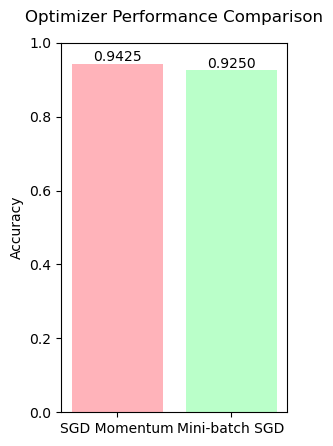

In [31]:
# Optimizer Comparison
plt.subplot(1, 2, 1)
optimizers = ['SGD Momentum', 'Mini-batch SGD']
accuracies = [
    np.mean(nn_momentum.predict(X_test) == y_test_labels),
    np.mean(nn_minibatch.predict(X_test) == y_test_labels)
]
bars = plt.bar(optimizers, accuracies, color=pastel_colors[:2])
plt.title('Optimizer Performance Comparison', pad=15)
plt.ylabel('Accuracy')
plt.ylim(0, 1)


# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

# Hyperparameters Visualization

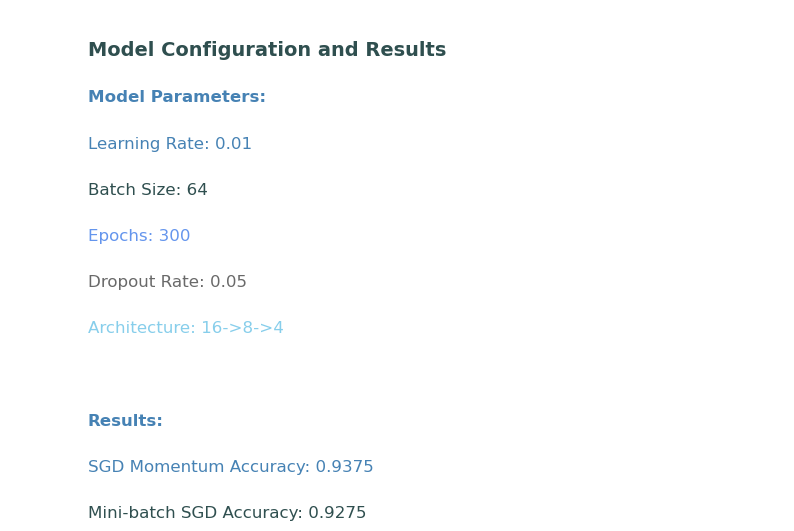

In [32]:
# Hyperparameters and Results Visualization
plt.figure(figsize=(10, 6))

# Create a table-like visualization for hyperparameters and results
params = {
   'Model Parameters': {
       'Learning Rate': 0.01,
       'Batch Size': 64, 
       'Epochs': 300,
       'Dropout Rate': 0.05,
       'Architecture': '16->8->4'
   },
   'Results': {
       'SGD Momentum Accuracy': f"{np.mean(nn_momentum.predict(X_test) == y_test_labels):.4f}",
       'Mini-batch SGD Accuracy': f"{np.mean(nn_minibatch.predict(X_test) == y_test_labels):.4f}"
   }
}

# Mix of blues and greys
colors = ['#4682B4',  # Steel Blue
         '#2F4F4F',  # Dark Slate Gray
         '#6495ED',  # Cornflower Blue
         '#696969',  # Dim Gray
         '#87CEEB']  # Sky Blue

# Clear table-like visualization
plt.text(0.1, 0.9, 'Model Configuration and Results', fontsize=14, fontweight='bold', color='#2F4F4F')  # Dark Slate Gray
y_pos = 0.8

# Parameters section
plt.text(0.1, y_pos, 'Model Parameters:', fontsize=12, fontweight='bold', color='#4682B4')  # Steel Blue
y_pos -= 0.1
for i, (param, value) in enumerate(params['Model Parameters'].items()):
   plt.text(0.1, y_pos, f"{param}: {value}", fontsize=12, color=colors[i % len(colors)])
   y_pos -= 0.1

# Results section
y_pos -= 0.1
plt.text(0.1, y_pos, 'Results:', fontsize=12, fontweight='bold', color='#4682B4')  # Steel Blue
y_pos -= 0.1
for i, (metric, value) in enumerate(params['Results'].items()):
   plt.text(0.1, y_pos, f"{metric}: {value}", fontsize=12, color=colors[i % len(colors)])
   y_pos -= 0.1

plt.axis('off')
plt.show()